# Layered HDBSCAN clustering

In [1]:
import numpy as np
from fast_hdbscan import HDBSCAN, LayerClustering

import requests
from io import BytesIO
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(rc={"figure.figsize": (8, 8)})

In [2]:
data_request = requests.get(
    "https://github.com/scikit-learn-contrib/hdbscan/blob/master/notebooks/clusterable_data.npy?raw=true"
)
data = np.load(BytesIO(data_request.content))

The layered clustering algorithm computes HDBSCAN* leaf clusters with an
increasing minimum cluster size threshold. The starting minimum cluster size is
specified by either `base_n_clusters` (binary search to a size that gives the
specified number of leaves) or `base_min_cluster_size` (initial value to use).
Then the `next_cluster_size_quantile` controls which size is used as the next
threshold. The process continues until `min_cluster` leaves remain or the size
increased by a single point. 

Each evaluated minimum cluster size creates a *layer* of cluster labels:

Layer 0 found 39 clusters
Layer 1 found 12 clusters
Layer 2 found 6 clusters
Layer 3 found 3 clusters


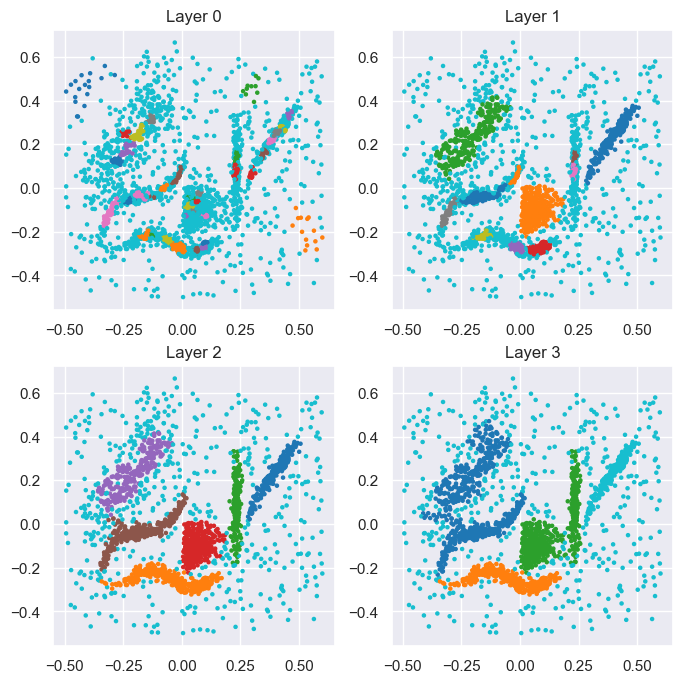

In [3]:
layers = LayerClustering(verbose=True).fit(data)

for i, labels in enumerate(layers.cluster_layers_):
    plt.subplot(2, 2, i + 1)
    plt.scatter(data[:, 0], data[:, 1], c=labels % 10, s=5, cmap="tab10", vmax=9, vmin=0)
    plt.title(f"Layer {i}")
plt.show()

The layer with the fewest noise points is selected as final clustering:

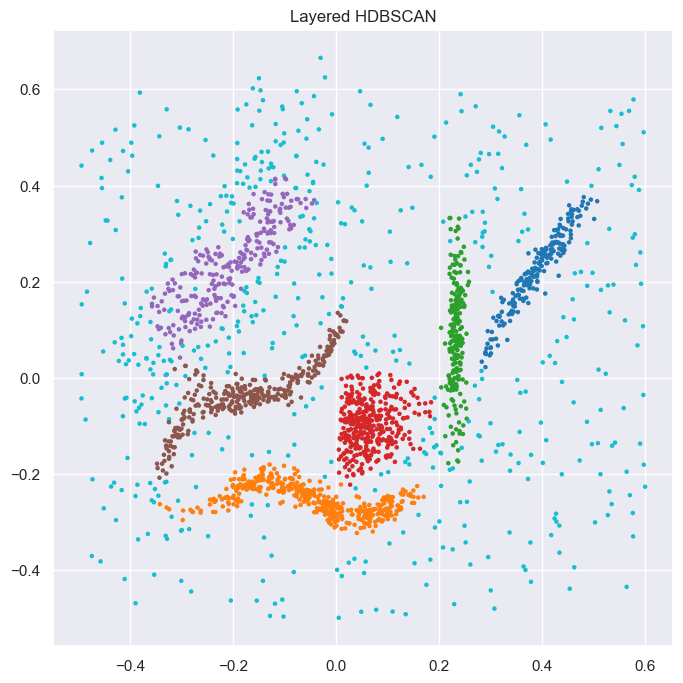

In [4]:
plt.scatter(data[:, 0], data[:, 1], c=layers.labels_ % 10, s=5, cmap="tab10", vmax=9, vmin=0)
plt.title("Layered HDBSCAN")
plt.show()

The clusters in these layers form a leaf-cluster tree, describing how the leaf
clusters merge at larger minimum sizes. The resulting hierarchy has edges across
multiple layers because a leaf's parent may not become a leaf immediately after 
the leaf's death. The resulting hierarchy is also not a binary tree. 

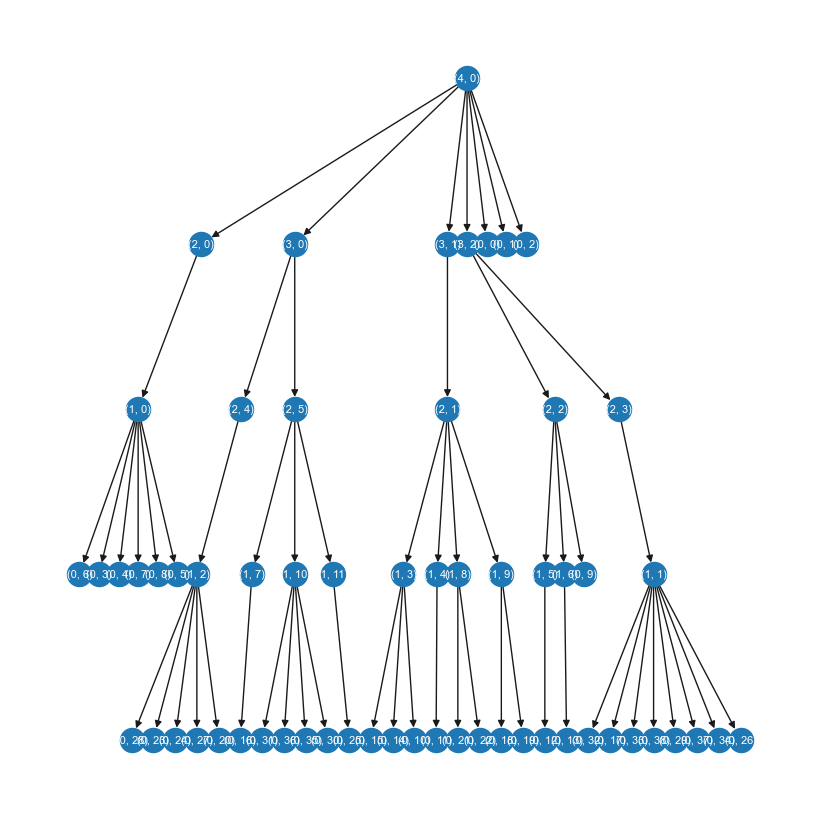

In [5]:
import networkx as nx

g = nx.from_dict_of_lists(layers.cluster_tree_, nx.DiGraph())
pos = nx.nx_agraph.graphviz_layout(g, prog="dot")
nx.draw(g, pos, with_labels=True, font_size=8, font_color="white")
plt.show()

## Exact multi-scale leave tree

It is possible to compute the exact leaf-cluster tree for a moving minimum
cluster size threshold. The idea is equivalent to computing a single linkage
hierarchy from a minimum spanning tree. The procedure below iterates over the
condensed tree leaves in increasing size. In each iteration all leaves with the
smallest size are processed. Their deaths are recorded and the remaining
condensed tree is inspected to determine whether the parent segment has become a
leaf. The process continuous until a single leaf remains and computes the
condensed hierarchy only once! 

In [6]:
# Output
leaves = dict() # {leaf_id: {birth: int, death: int, parent: int}}

# Compute initial condensed tree
min_size = 10
tree = HDBSCAN(min_samples=5, min_cluster_size=min_size).fit(data)._condensed_tree
cluster_tree = tree[tree["child_size"] > 1].copy()

# Find the leaves
n_points = data.shape[0]
n_nodes = cluster_tree["child"].max() + 1
leaf_mask = np.ones(n_nodes - n_points, dtype=np.bool_)
leaf_mask[cluster_tree["parent"] - n_points] = False
for leaf_id in np.where(leaf_mask)[0] + n_points:
    leaves[leaf_id] = dict(birth=int(min_size))

# Iteratively prune lowest size leaves
while leaf_mask.sum() > 1:
    # Extract rows with child leaves
    row_mask = leaf_mask[cluster_tree["child"] - n_points]
    leaf_sizes = cluster_tree["child_size"][row_mask]

    # Find the leaves sharing the smallest size (maybe use a queue instead?)
    leaf_ids = np.where(leaf_mask)[0] + n_points
    min_size = leaf_sizes.min()
    leaf_leaf_idx = np.where(leaf_sizes == min_size)[0]

    # Iterate over all leaves with the smallest size
    for leaf_id in leaf_ids[leaf_leaf_idx]:
        # Find the cluster tree row
        leaf_idx = np.searchsorted(cluster_tree["child"], leaf_id)
        parent = cluster_tree["parent"][leaf_idx]

        # Find the sibling row
        if leaf_idx > 0 and cluster_tree["parent"][leaf_idx - 1] == parent:
            sibling_idx = leaf_idx - 1
        else:
            sibling_idx = leaf_idx + 1
        sibling_id = cluster_tree["child"][sibling_idx]

        # Add the leaf's death and condensed tree parent
        leaves[leaf_id].update(dict(death=int(min_size + 1), parent=int(parent)))
        leaf_mask[leaf_id - data.shape[0]] = False

        # Update the cluster tree to skip the sibling
        cluster_tree["parent"][cluster_tree["parent"] == sibling_id] = parent
        cluster_tree["parent"][sibling_idx] = sibling_id
        cluster_tree["parent"][leaf_idx] = leaf_id

        # Check if sibling is a to-be-processed leaf
        if leaf_mask[sibling_id - data.shape[0]]:
            # Also add a death for the sibling
            leaves[sibling_id].update(dict(death=int(min_size + 1), parent=int(parent)))
            leaf_mask[sibling_id - data.shape[0]] = False
            # Add a birth for the parent
            leaves[parent] = dict(birth=int(min_size + 1))
            leaf_mask[parent - data.shape[0]] = True

# Use first cluster tree ancestor that becomes a leave as parent
cluster_tree = tree[tree["child_size"] > 1]
for child, attrs in leaves.items():
    if 'parent' not in attrs:
        continue
    parent = attrs["parent"]
    while parent not in leaves:
        idx = np.searchsorted(cluster_tree["child"], parent)
        parent = int(cluster_tree["parent"][idx])
    attrs["parent"] = parent

Computing the number of noise points at each minimum cluster size is trivial.
Births reduce the number of noise points, deaths increase the number of noise
points. Essentially this implements a group-by-sum operation.

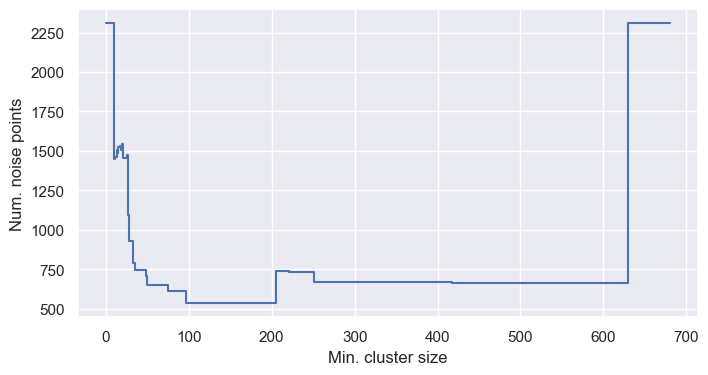

In [7]:
# List the number of points in each leaf birth and death
min_sizes = []
events = []
for leaf_id, attrs in leaves.items():
    tree_idx = np.searchsorted(cluster_tree["child"], leaf_id)
    item_size = cluster_tree["child_size"][tree_idx]
    min_sizes.append(attrs["birth"])
    events.append(-item_size)
    if "death" in attrs:
        min_sizes.append(attrs["death"])
        events.append(item_size)

# Sort the events by the minimum cluster size
min_sizes = np.asarray(min_sizes)
events = np.asarray(events)
order = np.argsort(min_sizes, kind="stable")
min_sizes = min_sizes[order]
events = events[order]

# Compute cumulative sum and extract the last event for each minimum size
noise_trace = np.cumsum(events) + data.shape[0]
indices = np.nonzero(np.diff(min_sizes) != 0)[0]
min_size_list = min_sizes[indices].tolist()
noise_trace_list = noise_trace[indices].tolist()

# Convert to square curve
inf_sep = 50
inf_value = int(min_size + 1 + inf_sep)  # or extracts max death from leaves
noise_trace_xs = np.vstack(
    (
        np.asarray([0] + min_size_list + [min_sizes[-1]]),
        np.asarray(min_size_list + [min_sizes[-1], inf_value]),
    )
).T.reshape(-1)
noise_trace_ys = np.vstack(
    (
        np.asarray([n_points] + noise_trace_list + [n_points]),
        np.asarray([n_points] + noise_trace_list + [n_points]),
    )
).T.reshape(-1)

plt.figure(figsize=(8, 4))
plt.plot(noise_trace_xs, noise_trace_ys)
plt.xlabel("Min. cluster size")
plt.ylabel("Num. noise points")
plt.show()

The optimal minimum cluster size has the lowest number of noise points, finding
the same labelling as `LayerClustering`:

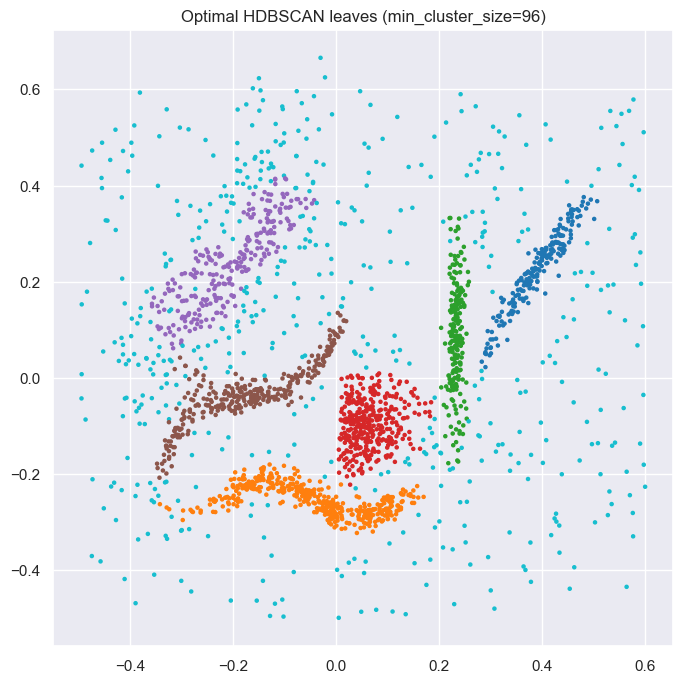

In [8]:
from fast_hdbscan.cluster_trees import (
    get_cluster_label_vector,
    get_point_membership_strength_vector,
)

best_size = min_sizes[np.argmin(noise_trace)]
select_leaves = [
    leaf_id
    for leaf_id, attrs in leaves.items()
    if attrs["birth"] <= best_size and attrs.get("death", np.inf) > best_size
]

labels = get_cluster_label_vector(tree, select_leaves, cluster_selection_epsilon=0.0, n_samples=n_points)
probs = get_point_membership_strength_vector(tree, select_leaves, labels)

plt.scatter(*data.T, c=labels % 10, s=5, cmap="tab10", vmax=9, vmin=0)
plt.title(f"Optimal HDBSCAN leaves (min_cluster_size={best_size})")
plt.show()

Plotting the leaf-cluster tree:

In [9]:
# List leaf-cluster children
children = dict()
for leaf_id, attrs in leaves.items():
    if "parent" not in attrs:
        continue
    parent = attrs["parent"]
    if parent not in children:
        children[parent] = []
    children[parent].append(leaf_id)


# Depth first traversal to order the leaf clusters
def df_tree_order(children, id):
    order = [id]
    if id not in children:
        return [id]
    for child in sorted(children[id], key=lambda x: leaves[x]["death"], reverse=True):
        order += df_tree_order(children, child)
    return order


# Add x-coordinates
root = tree["parent"][0]
for i, leaf in enumerate(df_tree_order(children, root)):
    leaves[leaf]["x"] = i

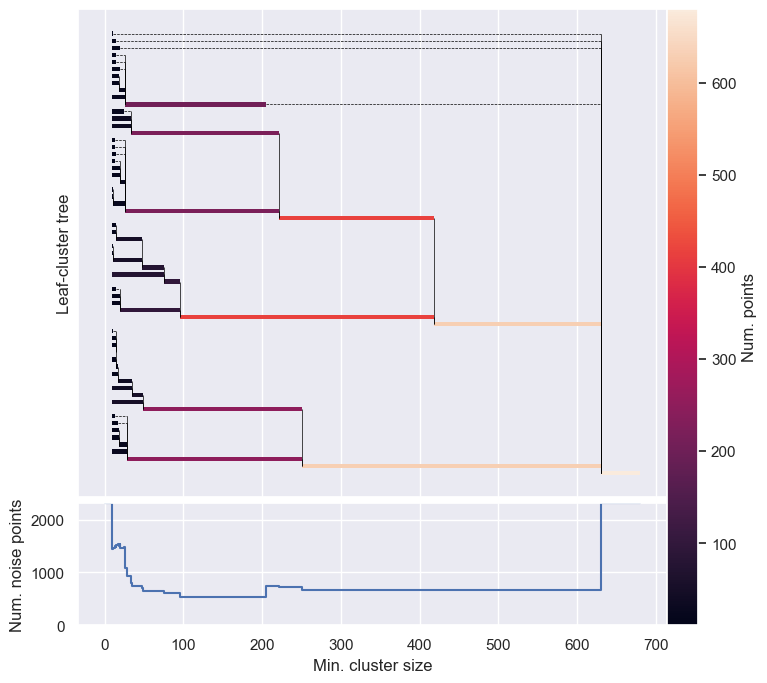

In [10]:
from matplotlib.collections import PatchCollection, LineCollection
from matplotlib.patches import Rectangle

leaf_separation = 0.6
rects = PatchCollection(
    [
        Rectangle(
            (leaf["birth"], leaf["x"] - leaf_separation / 2),
            leaf.get("death", inf_value) - leaf["birth"],
            leaf_separation,
        )
        for leaf in leaves.values()
    ],
    edgecolor="none",
)
rects.set_array([leaf.get("death", inf_value) for leaf in leaves.values()])
death_lines = LineCollection(
    [
        [(leaf["death"], leaf["x"]), (leaves[leaf["parent"]]["birth"], leaf["x"])]
        for leaf in leaves.values()
        if "death" in leaf
    ],
    linewidths=0.5,
    linestyle="--",
    color="black",
)
connecting_lines = LineCollection(
    [
        [
            (leaves[leaf["parent"]]["birth"], leaf["x"]),
            (leaves[leaf["parent"]]["birth"], leaves[leaf["parent"]]["x"]),
        ]
        for leaf in leaves.values()
        if "parent" in leaf
    ],
    linewidths=0.5,
    linestyle="-",
    color="black",
)

grid_kw = {"height_ratios": [0.8, 0.2], "width_ratios": [0.95, 0.05]}
fig, axes = plt.subplots(2, 2, sharex=True, gridspec_kw=grid_kw)
gs = axes[-1, -1].get_gridspec()
for ax in axes[:, -1]:
    ax.remove()

plt.sca(axes[0, 0])
axes[0, 0].add_collection(rects)
axes[0, 0].add_collection(death_lines)
axes[0, 0].add_collection(connecting_lines)
plt.autoscale()
plt.yticks([])
plt.ylabel("Leaf-cluster tree")

plt.sca(axes[1, 0])
plt.plot(noise_trace_xs, noise_trace_ys)
plt.ylabel("Num. noise points")
plt.xlabel("Min. cluster size")
plt.ylim(0, n_points)

ax = fig.add_subplot(gs[:, -1])
plt.colorbar(rects, cax=ax, label="Num. points")
plt.subplots_adjust(hspace=0.02, wspace=0)
plt.show()

Computing condensed-tree stability for leaf-clusters at the different minimum
cluster sizes:

- only compute persistence between min_cluster_size birth and death.
- consider points in all cluster_tree child segments.
- compute persistence as $\lambda_{enter} - \lambda{death}$
- compute stability as the sum of persistences for the points in a segment
  - The initial min cluster size points enter at the density at which the
    segment meets the minimum cluster size threshold!
  - Other points enter at their density in the condensed tree.
- plot the tree with `plt.pcolormesh`.
  - Icicle color and width by stability = $\sum{\lambda_{enter} - \lambda_{death}}$.

In [11]:
min_height = 0.05
max_height = (3 - min_height) / 2
cluster_tree = tree[tree["child_size"] > 1]
points_tree = tree[tree["child_size"] == 1]

In [106]:
def bf_children(cluster_tree, segment_id):
    """Extracts points in the condensed tree below the leaf_id segment."""
    to_process = [segment_id]
    result = []

    while len(to_process) > 0:
        result.extend(to_process)
        to_process = cluster_tree["child"][
            np.isin(cluster_tree["parent"], to_process, assume_unique=True)
        ]
    return result


def compute_leaf_trace(leaf_id, leaf):
    """Computes the lambda persistence curve of a leaf-cluster tree segment."""
    # Find the cluster's points in the condensed tree and list min, max size and
    # death density.
    min_size = leaf["birth"]
    if "death" in leaf:
        max_size = leaf["death"]
        segment_ids = bf_children(cluster_tree, leaf_id)
        segment_points = points_tree[np.isin(points_tree["parent"], segment_ids)]
        lambda_death = cluster_tree["lambda_val"][cluster_tree["child"] == leaf_id][0]
    else:
        max_size = min(inf_value + 2, points_tree.shape[0])
        segment_points = points_tree
        lambda_death = 0

    # Find lambda values for points entering the cluster within its size range.
    # The partition lets us sort just the points in the size range.
    leaf_size = segment_points.shape[0]
    indices = [leaf_size - max_size + 1, leaf_size - min_size + 1]
    lambdas = np.partition(segment_points["lambda_val"], indices)
    lambda_births = np.sort(lambdas[indices[0] : indices[1]])[::-1]

    # Create arrays for use with plt.pcolormesh
    #   min cluster size
    xs = np.arange(min_size, max_size)
    #   base bar location and height
    ys = np.asarray([leaf["x"] - min_height / 2, leaf["x"] + min_height / 2])
    #   persistence = lambda_births - lambda_death
    persistences = lambda_births - lambda_death
    #   stability = min_size * (birth - death) + sum(enter - death)
    stability = (xs - 1) * persistences + np.cumsum(persistences[::-1])[::-1]
    return (
        np.broadcast_to(xs, (len(ys), len(xs))),
        np.broadcast_to(ys[:, None], (len(ys), len(xs))),
        np.broadcast_to(stability, (len(ys), len(xs))),
    )

C:\Users\jelme\AppData\Local\Temp\ipykernel_1248\2272060407.py:39: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  bar = plt.pcolormesh(


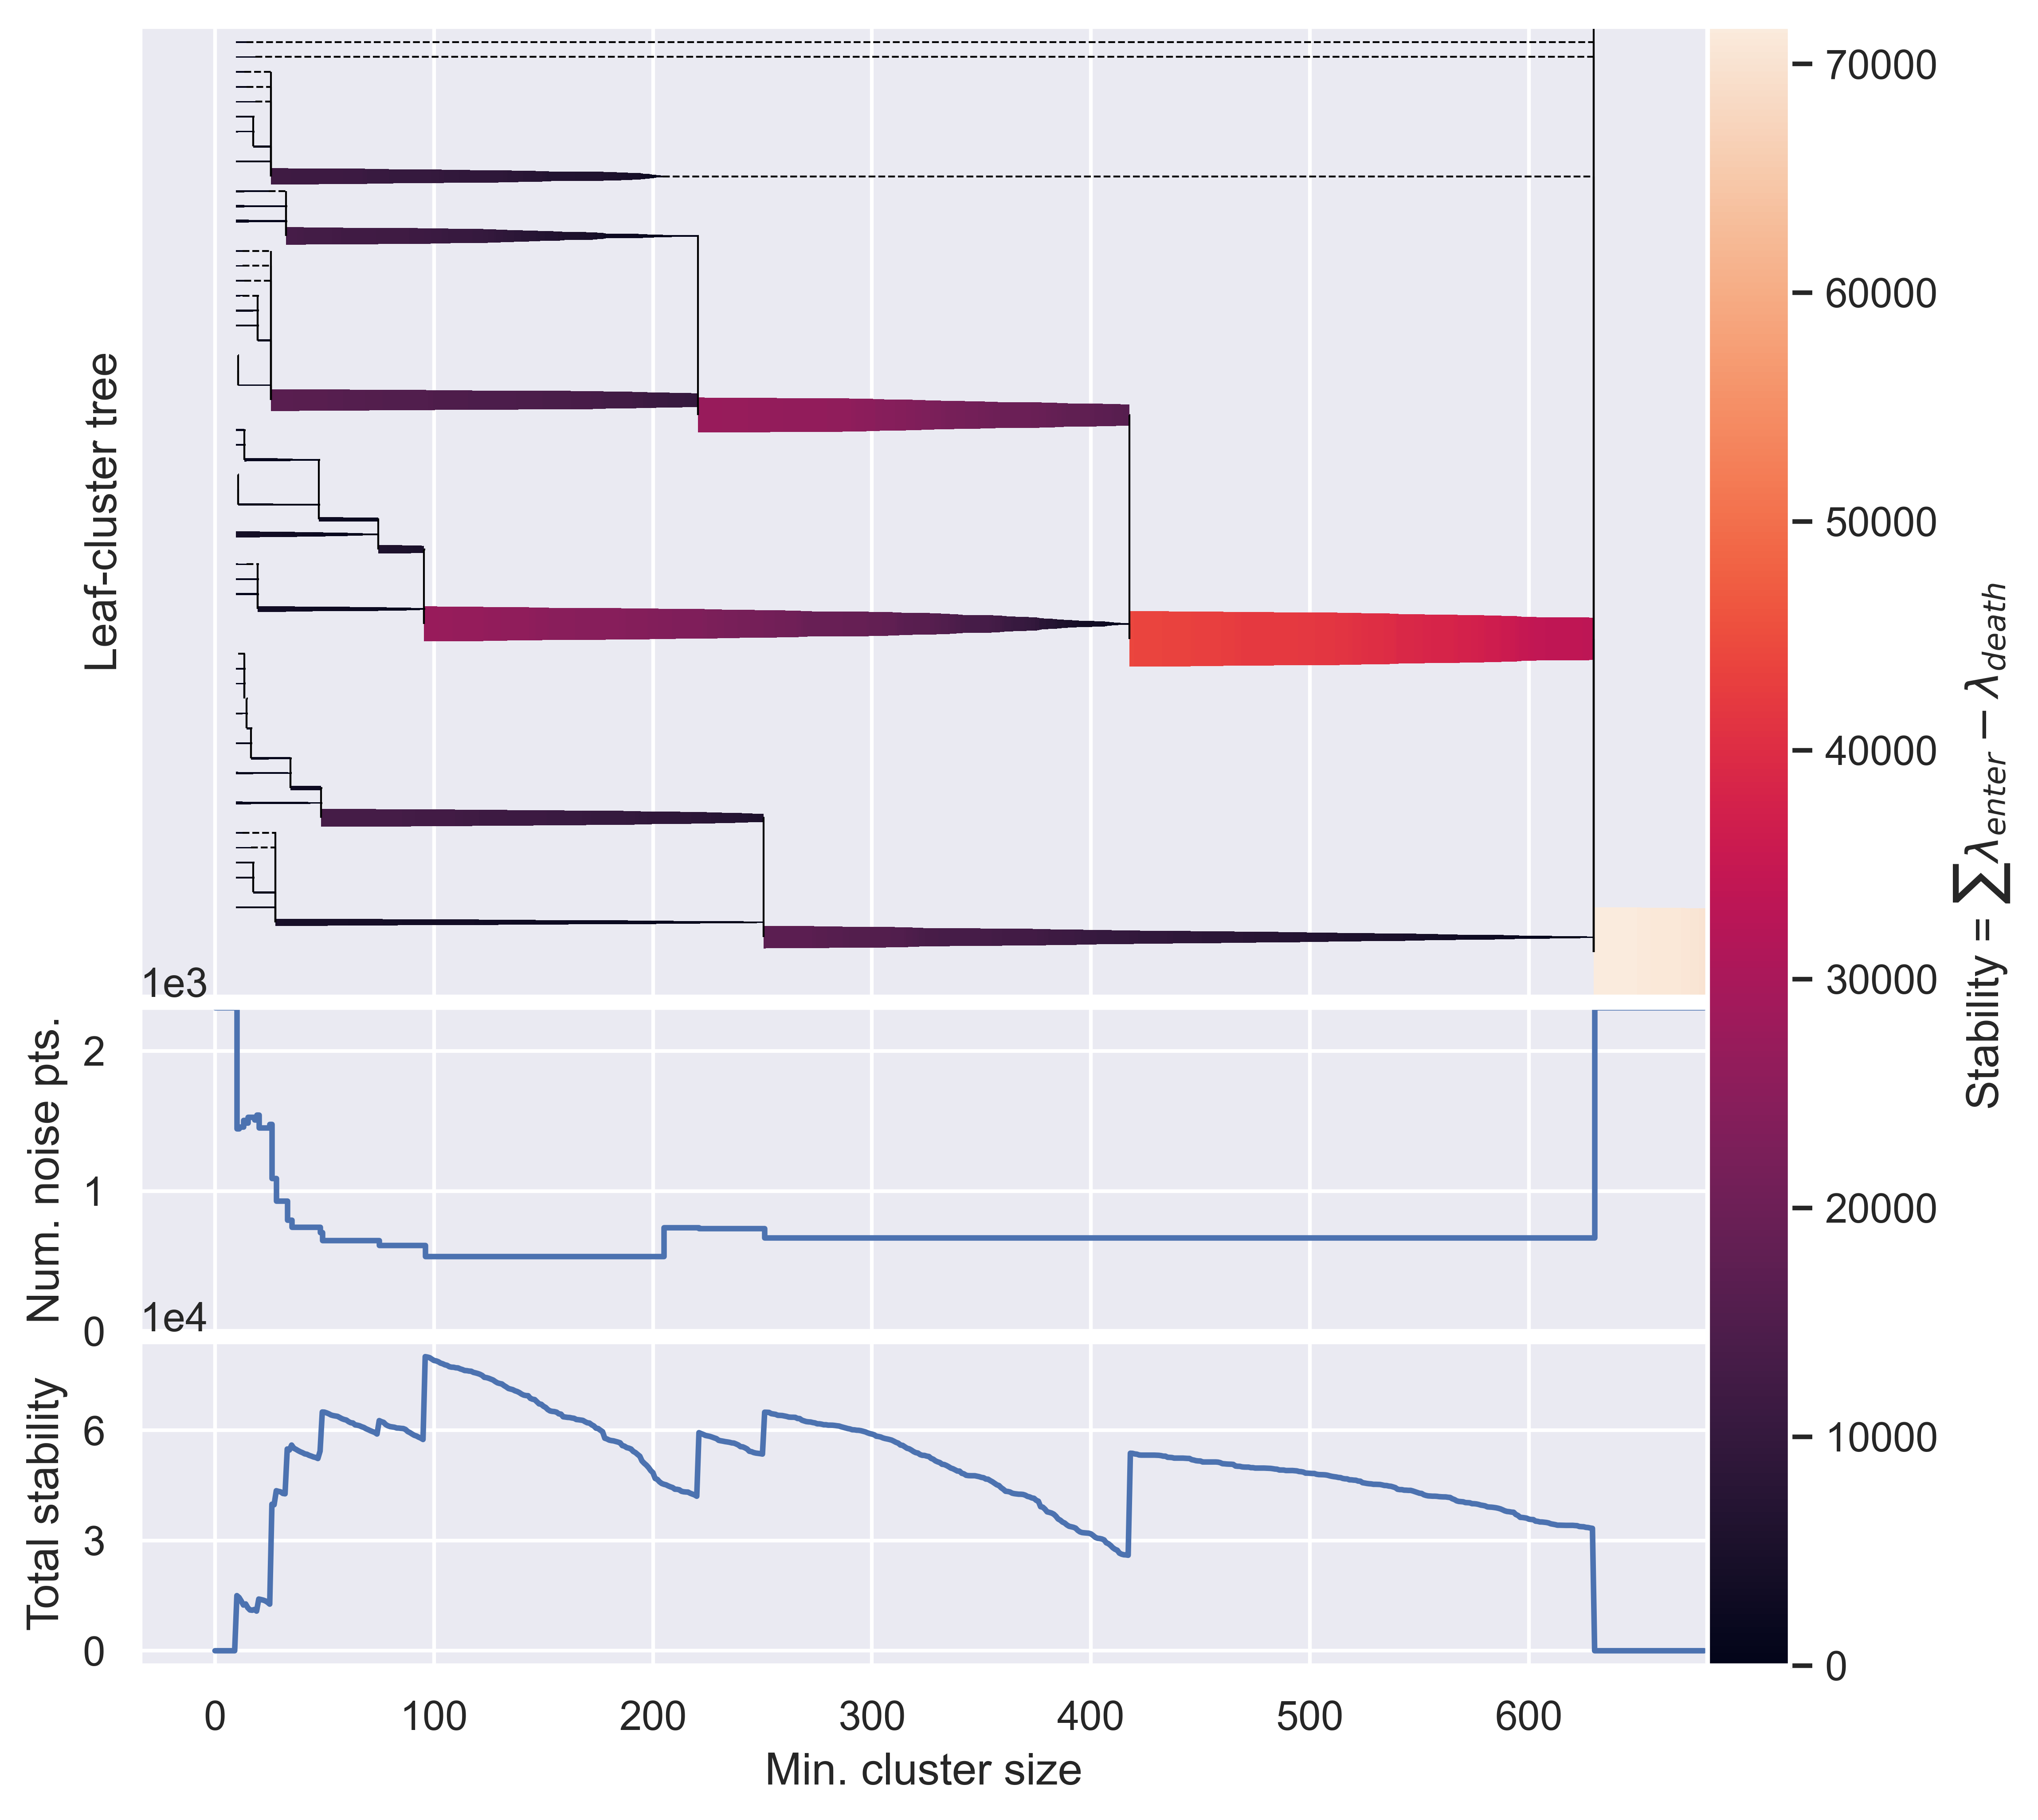

In [107]:
rects = [compute_leaf_trace(leaf_id, leaf) for leaf_id, leaf in leaves.items()]
death_lines = LineCollection(
    [
        [(leaf["death"] - 0.5, leaf["x"]), (leaves[leaf["parent"]]["birth"], leaf["x"])]
        for leaf in leaves.values()
        if "death" in leaf
    ],
    linewidths=0.5,
    linestyle="--",
    color="black",
)
connecting_lines = LineCollection(
    [
        [
            (leaves[leaf["parent"]]["birth"] - 0.5, leaf["x"]),
            (leaves[leaf["parent"]]["birth"] - 0.5, leaves[leaf["parent"]]["x"]),
        ]
        for leaf in leaves.values()
        if "parent" in leaf
    ],
    linewidths=0.5,
    linestyle="-",
    color="black",
)

grid_kw = {"height_ratios": [0.6, 0.2, 0.2], "width_ratios": [0.95, 0.05]}
fig, axes = plt.subplots(3, 2, sharex=True, gridspec_kw=grid_kw, dpi=600)
gs = axes[-1, -1].get_gridspec()
for ax in axes[:, -1]:
    ax.remove()

# Consistent color scale
plt.sca(axes[0, 0])
max_stab = max(np.max(r[2][0]) for r in rects)
for xs, ys, stabilities in rects:
    # ys create rectangle with constant min_height height
    # adding and subtracting scaled color signals makes the icicles
    heights = stabilities / max_stab * max_height * np.array([-1, 1])[:, None]
    bar = plt.pcolormesh(
        xs,
        ys + heights,
        stabilities,
        vmin=0,
        vmax=max_stab,
        edgecolors="none",
    )

axes[0, 0].add_collection(death_lines)
axes[0, 0].add_collection(connecting_lines)
plt.autoscale()
plt.yticks([])
plt.ylabel("Leaf-cluster tree")

plt.sca(axes[1, 0])
plt.plot(noise_trace_xs, noise_trace_ys)
plt.ylabel("Num. noise pts.")
plt.ylim(0, n_points)
plt.yticks([0, 1000, 2000])
plt.gca().ticklabel_format(axis="y", style="sci", scilimits=(0, 0))

# Stability per minimum cluster size.
#   stability = min_size * (birth - death) + sum(enter - death) for points entering later
agg = np.zeros(inf_value + 1)
for leaf, rect in zip(leaves.values(), rects):
    if "death" in leaf:
        agg[leaf["birth"] : leaf["death"]] += rect[2][0]

plt.sca(axes[2, 0])
plt.plot(agg)
plt.gca().ticklabel_format(axis="y", style="sci", scilimits=(0, 0))
plt.yticks([0, 30000, 60000])
plt.ylabel("Total stability")
plt.xlabel("Min. cluster size")


ax = fig.add_subplot(gs[:, -1])
plt.colorbar(bar, cax=ax, label="Stability = $\sum{\lambda_{enter} - \lambda_{death}}$")
plt.subplots_adjust(hspace=0.02, wspace=0)
plt.show()

A straight min_cluster_size cut seems most appropriate for this tree, regardless
of the measure being optimized. Maximizing the total stability works and relates
to minimizing the number of noise points. The total stability at a particular
minimum cluster size is a sum of density persistences over all points in the
clusters at that threshold. That signal contains the noise point trace. In
addition, the stability of each leaf-cluster is always largest at its birth. I
think that means that the total stability has a maximum when the number of noise
points is minimal. Maybe there are weird cases where it does not hold?